In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Importing the dataset
train_data = pd.read_csv("training_extra.csv")
test_data = pd.read_csv("train.csv")

In [4]:
train_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


In [5]:
test_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 310.0+ MB


In [7]:
num_train_rows, num_train_columns = train_data.shape

num_test_rows, num_test_columns = test_data.shape

print(f"Number of rows and columns in train data are {num_train_rows} and {num_train_columns}")
print(f"Number of rows and columns in test data are {num_test_rows} and {num_test_columns}")

Number of rows and columns in train data are 3694318 and 11
Number of rows and columns in test data are 300000 and 11


In [8]:
missing_values_train = pd.DataFrame({'Feature': train_data.columns,
                              '[Train] No. of Missing Values': train_data.isnull().sum().values,
                              '[Train] % of Missing Values': ((train_data.isnull().sum().values)/len(train_data)*100)})

missing_values_test = pd.DataFrame({'Feature': test_data.columns,
                             '[Test] No.of Missing Values': test_data.isnull().sum().values,
                             '[Test] % of Missing Values': ((test_data.isnull().sum().values)/len(test_data)*100)})

unique_values = pd.DataFrame({'Feature': train_data.columns,
                              'No. of Unique Values [Train]': train_data.nunique().values})

feature_types = pd.DataFrame({'Feature': train_data.columns,
                              'Data Type': train_data.dtypes})

merged_df = pd.merge(missing_values_train, missing_values_test, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values, on='Feature', how='left')
merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

merged_df                             

,Feature,[Train] No. of Missing Values,[Train] % of Missing Values,[Test] No.of Missing Values,[Test] % of Missing Values,No. of Unique Values [Train],Data Type
0,id,0,0.000000,0,0.000000,3694318,int64
1,Brand,117053,3.168460,9705,3.235000,5,object
2,Material,102615,2.777644,8347,2.782333,4,object
3,Size,81190,2.197699,6595,2.198333,3,object
4,Compartments,0,0.000000,0,0.000000,10,float64
5,Laptop Compartment,91089,2.465651,7444,2.481333,2,object
6,Waterproof,87274,2.362385,7050,2.350000,2,object
7,Style,96210,2.604270,7970,2.656667,3,object
8,Color,123667,3.347492,9950,3.316667,6,object
9,Weight Capacity (kg),1670,0.045205,138,0.046000,1783189,float64


In [9]:
# Count duplicate rows 
train_duplicates = train_data.duplicated().sum()
test_duplicates = test_data.duplicated().sum()
print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0


In [10]:
train_data.describe()

,id,Compartments,Weight Capacity (kg),Price
count,3.694318e+06,3.694318e+06,3.692648e+06,3.694318e+06
mean,2.347158e+06,5.434022e+00,1.800883e+01,8.135820e+01
std,1.066458e+06,2.893227e+00,6.974541e+00,3.893050e+01
min,5.000000e+05,1.000000e+00,5.000000e+00,1.500000e+01
25%,1.423579e+06,3.000000e+00,1.206854e+01,4.747778e+01
50%,2.347158e+06,5.000000e+00,1.805243e+01,8.098592e+01
75%,3.270738e+06,8.000000e+00,2.398580e+01,1.148434e+02
max,4.194317e+06,1.000000e+01,3.000000e+01,1.500000e+02


### Dataset Shape

- Training Data: 36,94,318 rows × 11 columns
- Test Data: 300,000 rows × 11 columns

### Missing Values Analysis

- **Color**: ~3.35% missing in train, ~3.32% in test  
- **Brand**: ~3.17% missing in train, ~3.24% in test  
- **Material**: ~2.78% missing in train, ~2.78% in test  
- **Size**: ~2.20% missing in train, ~2.20% in test  
- **Style**: ~2.60% missing in train, ~2.66% in test  
- **Laptop Compartment**: ~2.47% missing in train, ~2.48% in test  
- **Waterproof**: ~2.36% missing in train, ~2.35% in test  
- **Weight Capacity (kg)**: ~0.05% missing in train, ~0.046% in test  


# EDA

In [11]:
numerical_variables = ['Weight Capacity (kg)']
target_variable = 'Price' 
categorical_variables = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment','Waterproof', 'Style', 'Color']

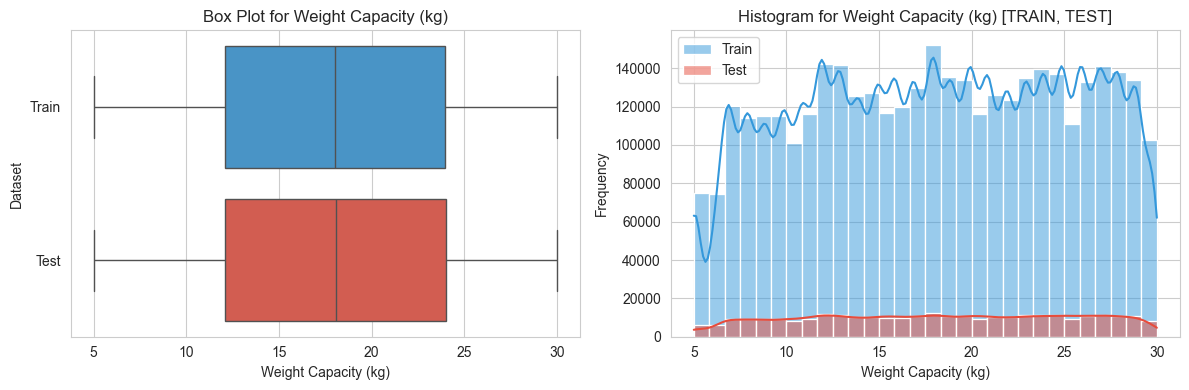

In [12]:
#Analyse Weight Capacity (kg) variable

custom_palette = ['#3498db', '#e74c3c']

train_temp = train_data.copy()
test_temp = test_data.copy()

train_temp['Dataset'] = 'Train'
test_temp['Dataset'] = 'Test'

train_temp.reset_index(drop=True, inplace=True)
test_temp.reset_index(drop=True, inplace=True)

variables = [col for col in train_temp.columns if col in numerical_variables]

# Function to create and display the plots
def create_variable_plots(variable):
    sns.set_style('whitegrid')
    
    plt.subplots(1, 2, figsize=(12, 4))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=pd.concat([train_temp, test_temp], ignore_index=True), 
                x=variable, y="Dataset", palette=custom_palette)
    plt.xlabel(variable)
    plt.title(f"Box Plot for {variable}")

    # Separate Histograms
    plt.subplot(1, 2, 2)
    sns.histplot(data=train_temp, x=variable, color=custom_palette[0], kde=True, bins=30, label="Train")
    sns.histplot(data=test_temp, x=variable, color=custom_palette[1], kde=True, bins=30, label="Test")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {variable} [TRAIN, TEST]")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Perform univariate analysis for each variable
for variable in variables:
    create_variable_plots(variable)

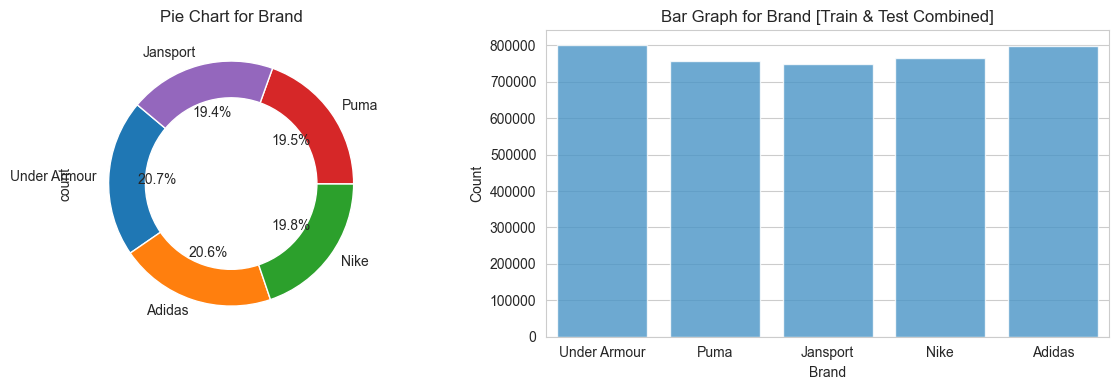

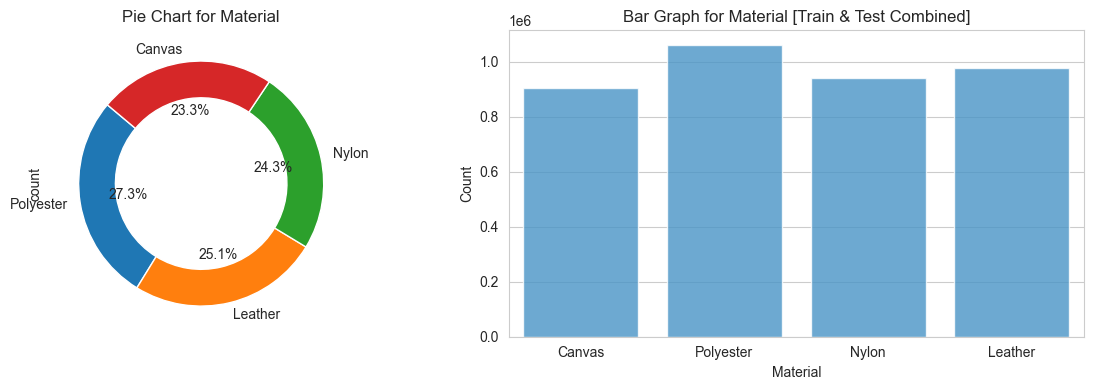

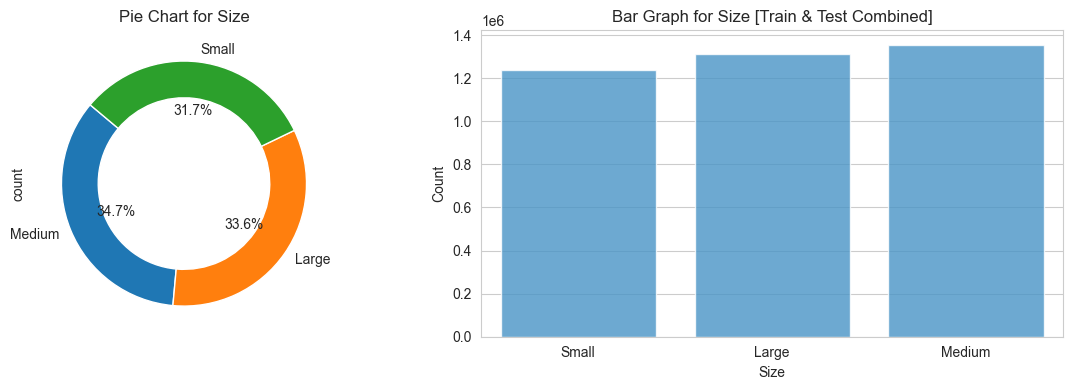

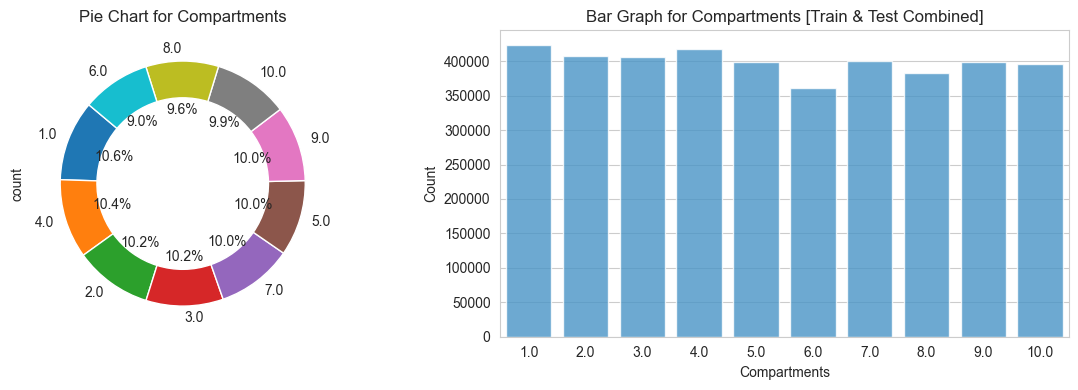

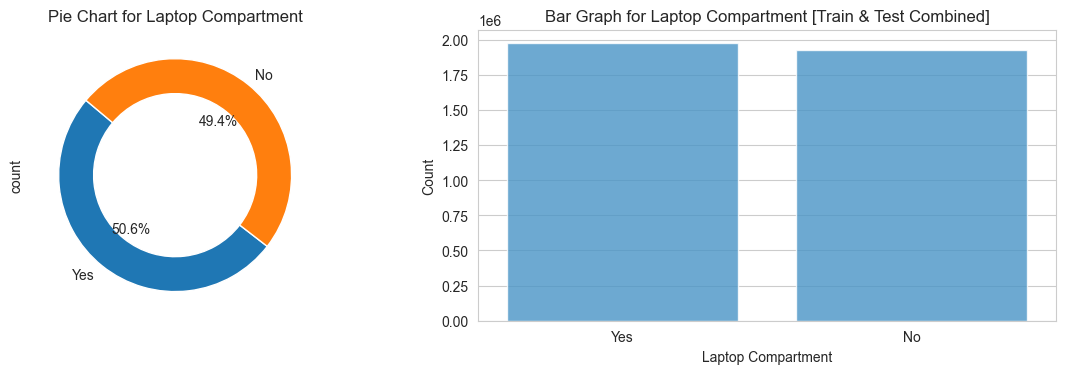

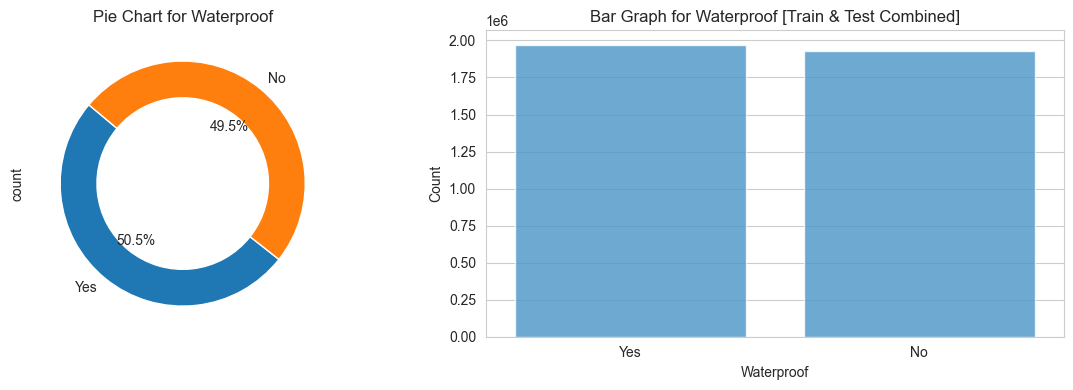

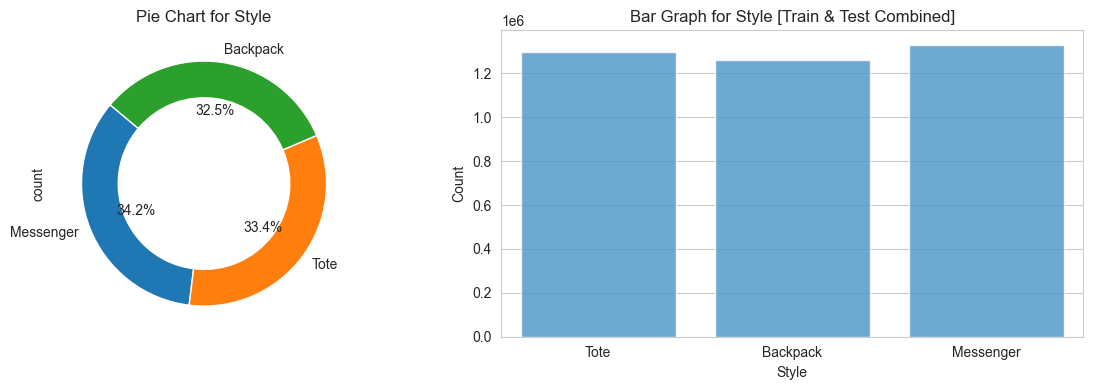

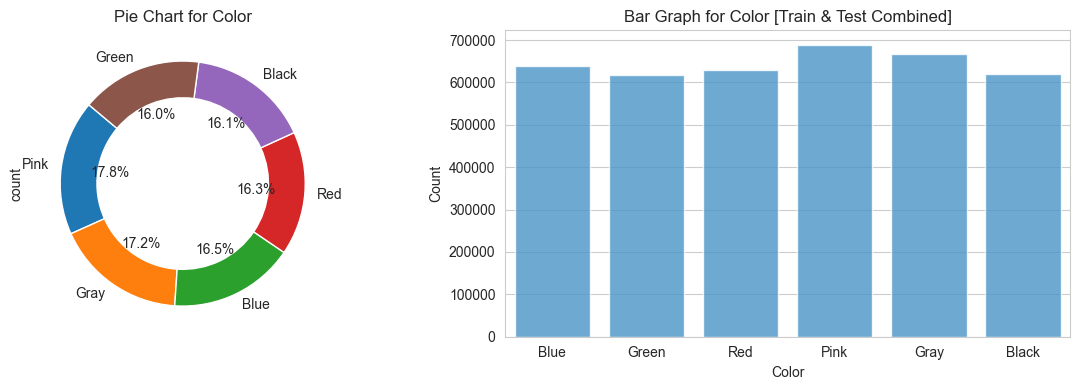

In [13]:
def create_categorical_plots(variable):
    sns.set_style('whitegrid')
    
    plt.subplots(1, 2, figsize=(12, 4))

    # Pie Chart
    plt.subplot(1, 2, 1)
    train_data[variable].value_counts().plot.pie(
        autopct='%1.1f%%',  wedgeprops=dict(width=0.3), startangle=140)
    plt.title(f"Pie Chart for {variable}")

    # Bar Graph
    plt.subplot(1, 2, 2)
    sns.countplot(
        data=pd.concat([train_data, test_data ]).reset_index(drop=True), 
        x=variable, 
        color= '#3498db',
        alpha=0.8 )

    plt.xlabel(variable)
    plt.ylabel("Count")
    plt.title(f"Bar Graph for {variable} [Train & Test Combined]")

    plt.tight_layout()
    plt.show()

# Perform univariate analysis for each categorical variable
for variable in categorical_variables:
    create_categorical_plots(variable)

# Data Preprocessing

In [14]:
# Fill categorical missing values with mode (most frequent value)
for col in categorical_variables:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)
    test_data[col].fillna(test_data[col].mode()[0], inplace=True)

# Fill numerical missing values with median
for col in numerical_variables:
    train_data[col].fillna(train_data[col].median(), inplace=True)
    test_data[col].fillna(test_data[col].median(), inplace=True)

# Feature Engineering 
( Add some more variables whose interaction would affect the price of the bag)

In [15]:
from sklearn.preprocessing import LabelEncoder

def perform_feature_engineering(df):
    # Brand Material Interaction - Certain materials may be common for specific brands
    df['Brand_Material'] = df['Brand'] + '_' + df['Material']

    # Brand & Size Interaction - Some brands may produce only specific sizes
    df['Brand_Size'] = df['Brand'] + '_' + df['Size']

    # Has Laptop Compartment - Convert Yes/No to 1/0 for easier analysis
    df['Has_Laptop_Compartment'] = df['Laptop Compartment'].map({'Yes': 1, 'No': 0})

    # Is Waterproof - Convert Yes/No to 1/0 for easier analysis
    df['Is_Waterproof'] = df['Waterproof'].map({'Yes': 1, 'No': 0})

    # Compartments Binning - Group compartments into categories
    df['Compartments_Category'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Too Many'])

    # Weight Capacity Ratio - Normalize weight capacity using the max value
    df['Weight_Capacity_Ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    # Interaction Feature: Weight vs. Compartments - Some bags may hold more with less compartments
    df['Weight_to_Compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)  # Avoid division by zero

    # Style and Size Interaction - Certain styles may correlate with sizes
    df['Style_Size'] = df['Style'] + '_' + df['Size']

    return df

# Apply the function to the training data
train_data = perform_feature_engineering(train_data)

# Apply the function to the test data
test_data = perform_feature_engineering(test_data)

In [16]:
id_test = test_data['id']

columns_to_drop = ['id']
train_data.drop(columns_to_drop, axis=1, inplace=True)
test_data.drop(columns_to_drop, axis=1, inplace=True)

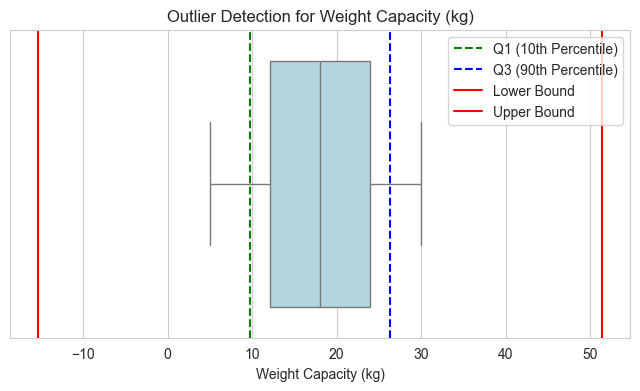

Rows deleted for Weight Capacity (kg): 0


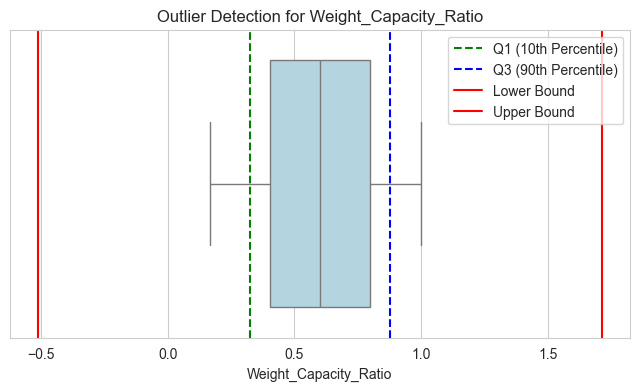

Rows deleted for Weight_Capacity_Ratio: 0


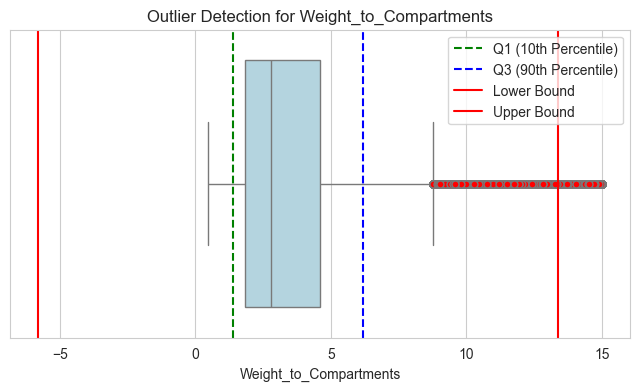

Rows deleted for Weight_to_Compartments: 51877
Total rows deleted: 51877


In [17]:
# Check for outliers and remove them from the dataset

columns_to_check = ['Weight Capacity (kg)','Weight_Capacity_Ratio','Weight_to_Compartments']

# Function to remove outliers using IQR and visualize
def remove_outliers_iqr_with_plot(data, column):
    Q1 = data[column].quantile(0.15)
    Q3 = data[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the data
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    # Calculate the number of rows deleted
    rows_deleted = len(data) - len(filtered_data)
    
    # Plot the distribution with outliers
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column], color='lightblue', flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'})
    
    # Highlight Q1 and Q3
    plt.axvline(Q1, color='green', linestyle='--', label='Q1 (10th Percentile)')
    plt.axvline(Q3, color='blue', linestyle='--', label='Q3 (90th Percentile)')
    
    # Highlight lower and upper bounds
    plt.axvline(lower_bound, color='red', linestyle='-', label='Lower Bound')
    plt.axvline(upper_bound, color='red', linestyle='-', label='Upper Bound')

    plt.title(f'Outlier Detection for {column}')
    plt.legend()
    plt.xlabel(column)
    plt.show()
    
    return filtered_data, rows_deleted

# Apply function to each numerical column and visualize
rows_deleted_total = 0

for column in columns_to_check:
    train_data, rows_deleted = remove_outliers_iqr_with_plot(train_data, column)
    rows_deleted_total += rows_deleted
    print(f"Rows deleted for {column}: {rows_deleted}")

print(f"Total rows deleted: {rows_deleted_total}")

In [18]:
train_data.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Brand_Material,Brand_Size,Has_Laptop_Compartment,Is_Waterproof,Compartments_Category,Weight_Capacity_Ratio,Weight_to_Compartments,Style_Size
0,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068,Under Armour_Canvas,Under Armour_Small,1,1,Many,0.796068,2.171096,Tote_Small
1,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972,Puma_Polyester,Puma_Small,0,1,Moderate,0.395637,2.373819,Backpack_Small
2,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370,Jansport_Polyester,Jansport_Small,1,1,Many,0.269743,0.899145,Tote_Small
3,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209,Nike_Nylon,Nike_Large,0,0,Many,0.257319,0.964948,Messenger_Large
4,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461,Nike_Leather,Nike_Large,0,1,Many,0.758061,2.274183,Tote_Large


In [19]:
train_data['Compartments_Category'].unique()

['Many', 'Moderate', 'Few']
Categories (4, object): ['Few' < 'Moderate' < 'Many' < 'Too Many']

In [20]:
brand_mapping = {'Under Armour': 0, 'Puma': 1, 'Jansport': 2, 'Nike': 3, 'Adidas': 4}
material_mapping = {'Canvas': 0, 'Polyester': 1, 'Nylon': 2, 'Leather': 3}
size_mapping = {'Small': 0, 'Medium': 1, 'Large': 2}
laptop_comp_mapping = {'Yes': 1, 'No': 0}
waterproof_mapping = {'Yes': 1, 'No': 0}
style_mapping = {'Tote': 0, 'Messenger': 1, 'Backpack': 2}
color_mapping = {'Blue': 0, 'Green': 1, 'Red': 2, 'Pink': 3, 'Gray': 4, 'Black': 5}
brand_material_mapping= {
    'Jansport_Leather': 0, 'Jansport_Canvas': 1, 'Jansport_Nylon': 2, 'Jansport_Polyester': 3,
    'Nike_Leather': 4, 'Nike_Canvas': 5, 'Nike_Nylon': 6, 'Nike_Polyester': 7,
    'Adidas_Leather': 8, 'Adidas_Canvas': 9, 'Adidas_Nylon': 10, 'Adidas_Polyester': 11,
    'Puma_Leather': 12, 'Puma_Canvas': 13, 'Puma_Nylon': 14, 'Puma_Polyester': 15,
    'Under Armour_Leather': 16, 'Under Armour_Canvas': 17, 'Under Armour_Nylon': 18, 'Under Armour_Polyester': 19}
brand_size_mapping = {
    'Jansport_Large': 0, 'Jansport_Medium': 1, 'Jansport_Small': 2,
    'Nike_Large': 3, 'Nike_Medium': 4, 'Nike_Small': 5,
    'Adidas_Large': 6, 'Adidas_Medium': 7, 'Adidas_Small': 8,
    'Puma_Large': 9, 'Puma_Medium': 10, 'Puma_Small': 11,
    'Under Armour_Large': 12, 'Under Armour_Medium': 13, 'Under Armour_Small': 14}
compartments_category_mapping = {'Few': 0, 'Moderate': 1, 'Many': 2, 'Too Many': 3}
style_size_mapping = {
    'Messenger_Large': 0, 'Messenger_Medium': 1, 'Messenger_Small': 2,
    'Backpack_Large': 3, 'Backpack_Medium': 4, 'Backpack_Small': 5,
    'Tote_Large': 6, 'Tote_Medium': 7, 'Tote_Small': 8 }


In [21]:
categorical_mappings = {
    'Brand': brand_mapping,
    'Material': material_mapping,
    'Size': size_mapping,
    'Laptop Compartment': laptop_comp_mapping,
    'Waterproof': waterproof_mapping,
    'Style': style_mapping,
    'Color': color_mapping,
    'Brand_Material': brand_material_mapping,
    'Brand_Size': brand_size_mapping,
    'Compartments_Category': compartments_category_mapping,
    'Style_Size': style_size_mapping
}

In [22]:
for col, mapping in categorical_mappings.items():
    train_data[col] = train_data[col].map(mapping)
    test_data[col] = test_data[col].map(mapping)

In [23]:
train_data['Compartments_Category'].dtype

CategoricalDtype(categories=[0, 1, 2, 3], ordered=True, categories_dtype=int64)

In [24]:
train_data

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Brand_Material,Brand_Size,Has_Laptop_Compartment,Is_Waterproof,Compartments_Category,Weight_Capacity_Ratio,Weight_to_Compartments,Style_Size
0,0,0,0,10.0,1,1,0,0,23.882052,114.11068,17,14,1,1,2,0.796068,2.171096,8
1,1,1,0,4.0,0,1,2,1,11.869095,129.74972,15,11,0,1,1,0.395637,2.373819,5
2,2,1,0,8.0,1,1,0,2,8.092302,21.37370,3,2,1,1,2,0.269743,0.899145,8
3,3,2,2,7.0,0,0,1,3,7.719581,48.09209,6,3,0,0,2,0.257319,0.964948,0
4,3,3,2,9.0,0,1,0,1,22.741826,77.32461,4,3,0,1,2,0.758061,2.274183,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694313,3,0,1,3.0,1,1,1,0,28.098120,104.74460,5,4,1,1,1,0.936604,7.024530,1
3694314,1,3,0,10.0,1,1,0,0,17.379531,122.39043,12,11,1,1,2,0.579318,1.579957,8
3694315,2,0,2,10.0,0,0,2,2,17.037708,148.18470,1,0,0,0,2,0.567924,1.548883,3
3694316,1,0,1,2.0,0,0,2,4,28.783339,22.32269,13,10,0,0,0,0.959445,9.594446,4


# Machine Learning Models
(Using Various Models & Evaluating the best model)

Models used:
- Random Forest Regressor
- Neural Networks
- XGBoost Regressor
- LightGBM Regressor
- CatBoost Regressor

In [25]:
# Taking 1 lac rows for training the model
train_data = train_data.sample(n=500000, random_state=42)
X_train = train_data.drop(['Price'], axis=1)
Y_train = train_data['Price']
X_test= test_data.drop(['Price'], axis=1)
Y_test= test_data['Price']
X_train.shape

(500000, 17)

In [26]:
def evaluate_model(model, x_train, x_test, y_train, y_test, model_name):
    model.fit(x_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {test_r2:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Validation MAE: {test_mae:.4f}")
    
    return model, test_rmse, test_r2, model_name

In [27]:
# Using Random Forest Regressor
print("Random Forest Regressor")
rr_model = RandomForestRegressor(random_state=42)
rr_results = evaluate_model(rr_model, X_train, X_test, Y_train, Y_test, "Random Forest Regressor")

Random Forest Regressor

Random Forest Regressor Results:
Training RMSE: 15.0681
Validation RMSE: 40.4115
Training R²: 0.8497
Validation R²: -0.0715
Training MAE: 12.7375
Validation MAE: 34.5856


In [28]:
# Using XGBoost Regressor
print("\nTraining XGBoost Regressor...")
xgb_model = xgb.XGBRegressor(learning_rate=0.1, random_state=42, enable_categorical=True) # Enable_categorial is set to true to handle categorical variables
xgb_results = evaluate_model(xgb_model, X_train, X_test, Y_train, Y_test, "XGBoost")


Training XGBoost Regressor...

XGBoost Results:
Training RMSE: 38.6591
Validation RMSE: 39.0242
Training R²: 0.0109
Validation R²: 0.0008
Training MAE: 33.4053
Validation MAE: 33.7639


In [29]:
# Using LightGBM Regressor
print("\nTraining LightGBM Regressor...")
lgb_model = lgb.LGBMRegressor(learning_rate=0.1, random_state=42)
lgb_results = evaluate_model(lgb_model, X_train, X_test, Y_train, Y_test, "LightGBM")


Training LightGBM Regressor...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 17
[LightGBM] [Info] Start training from score 81.377538

LightGBM Results:
Training RMSE: 38.7224
Validation RMSE: 39.0157
Training R²: 0.0077
Validation R²: 0.0012
Training MAE: 33.4649
Validation MAE: 33.7619


In [30]:
# Using CatBoost Regressor
print("\nTraining CatBoost Regressor...")
cb_model = CatBoostRegressor(
    learning_rate=0.1, 
    random_seed=42, 
    verbose=0)

categorical_features = ['Brand', 'Material', 'Size', 'Style', 'Color','Brand_Material', 'Brand_Size', 'Compartments_Category', 'Style_Size']

for col in categorical_features:
    X_train[col] = X_train[col].astype('int')
    X_test[col] = X_test[col].astype('int')

# Train and evaluate the model
cb_results = evaluate_model(cb_model, X_train, X_test, Y_train, Y_test, "CatBoost")


Training CatBoost Regressor...

CatBoost Results:
Training RMSE: 38.4986
Validation RMSE: 39.0678
Training R²: 0.0191
Validation R²: -0.0015
Training MAE: 33.2547
Validation MAE: 33.7873


In [31]:
# Neural Network
def create_nn_model(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [32]:
# Scale data for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Train neural network
print("\nTraining Neural Network...")
nn_model = create_nn_model(X_train.shape[1])
history = nn_model.fit(
    X_train_scaled, Y_train,
    validation_data=(X_test_scaled, Y_test),
    epochs=30,
    batch_size=64,
    verbose=0)


Training Neural Network...


In [35]:
nn_results= evaluate_model(model= nn_model, x_train= X_train_scaled, x_test= X_test_scaled, y_train= Y_train, y_test= Y_test, model_name= "Neural Network")

15625/15625 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - loss: 1511.4968 - mae: 33.6010
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step

Neural Network Results:
Training RMSE: 38.8353
Validation RMSE: 39.1657
Training R²: 0.0019
Validation R²: -0.0065
Training MAE: 33.5711
Validation MAE: 33.8509


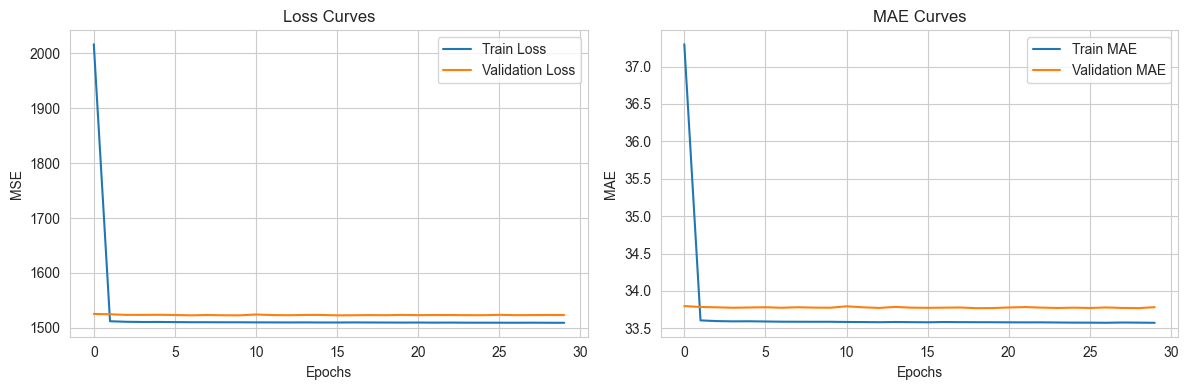

In [36]:
# Plot neural network learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Curves')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Store all model results
models_results = [rr_results, xgb_results, lgb_results, cb_results, nn_results]

In [38]:
# Compare model performances
models_df = pd.DataFrame({
    'Model': [result[3] for result in models_results],
    'Validation RMSE': [result[1] for result in models_results],
    'Validation R²': [result[2] for result in models_results]
}).sort_values('Validation RMSE')

print("\nModel Performance Comparison:")
print(models_df)


Model Performance Comparison:
                     Model  Validation RMSE  Validation R²
2                 LightGBM        39.015746       0.001205
1                  XGBoost        39.024231       0.000771
3                 CatBoost        39.067817      -0.001463
4           Neural Network        39.165720      -0.006488
0  Random Forest Regressor        40.411469      -0.071534


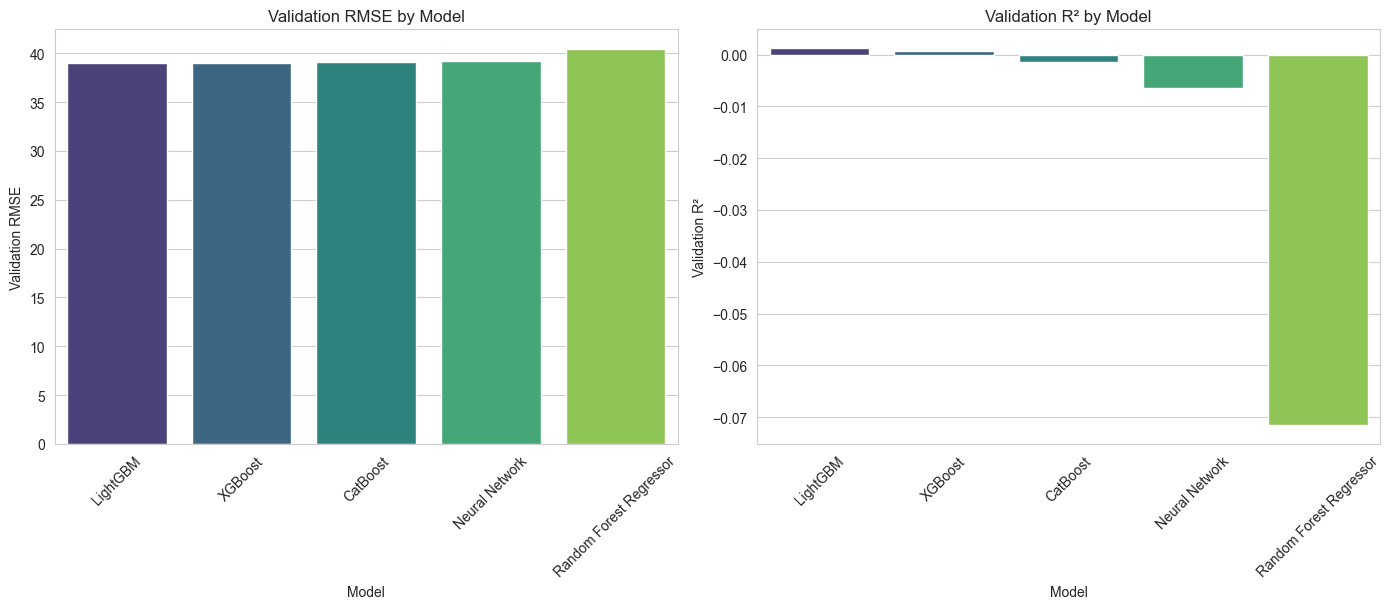

In [39]:
# Plot model comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Validation RMSE', data=models_df, palette='viridis')
plt.title('Validation RMSE by Model')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Validation R²', data=models_df, palette='viridis')
plt.title('Validation R² by Model')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplots_adjust(bottom=0.25)  # Adjust to prevent x-labels cutoff
plt.show()


In [40]:
# Find best model based on validation RMSE
best_model_idx = models_df['Validation RMSE'].idxmin()
best_model_name = models_df.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model_name}")


Best performing model: LightGBM


# Submission for Kaggle Competition

In [43]:
test_1 = pd.read_csv("test.csv")
test_1 = perform_feature_engineering(test_1)
for col, mapping in categorical_mappings.items():
    test_1[col] = test_1[col].map(mapping)

test_2= test_1.drop(columns_to_drop, axis=1)
price_prediction= models_results[best_model_idx][0].predict(test_2)    

In [48]:
id_test = test_1['id']

In [49]:
submission = pd.DataFrame({
    'id': id_test,
    'Price': price_prediction
})
submission.to_csv('model_predictions.csv', index=False)
print("\nPredictions saved to 'model_predictions.csv'")


Predictions saved to 'model_predictions.csv'
